GRAMMATICAL EVOLUTION FEATURE SELECTION EXPERIMENT
Loading and preprocessing data...
Dataset shape: (211, 32)
Number of classes: 2
Target distribution: [148  63]

RUN 1/30
Starting evolution with 70 individuals...
Generation 1: Best = 0.9851 | Avg = 0.6908
Generation 2: Best = 0.9851 | Avg = 0.7227
Generation 3: Best = 0.9851 | Avg = 0.7735
Generation 4: Best = 0.9851 | Avg = 0.8184
Generation 5: Best = 0.9851 | Avg = 0.8814
Generation 6: Best = 0.9851 | Avg = 0.8946
Generation 7: Best = 0.9851 | Avg = 0.9208
Generation 8: Best = 0.9851 | Avg = 0.8787
Generation 9: Best = 0.9851 | Avg = 0.8816
Generation 10: Best = 0.9851 | Avg = 0.9106
Generation 11: Best = 0.9851 | Avg = 0.9074
Generation 12: Best = 0.9851 | Avg = 0.9091
Generation 13: Best = 0.9851 | Avg = 0.9245
Generation 14: Best = 0.9851 | Avg = 0.8865
Generation 15: Best = 0.9851 | Avg = 0.9185
Generation 16: Best = 0.9851 | Avg = 0.9118
Generation 17: Best = 0.9851 | Avg = 0.8937
Generation 18: Best = 0.9851 | Avg = 0.9295
Gen

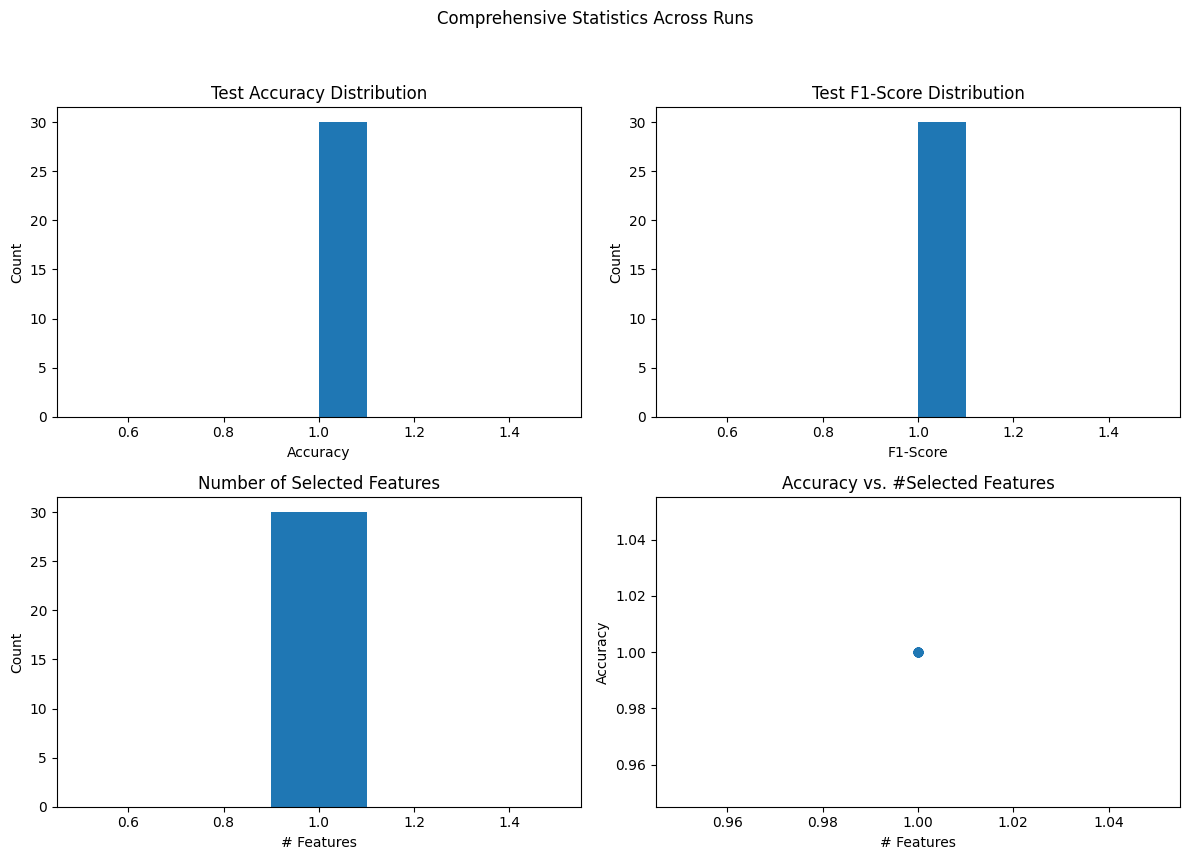

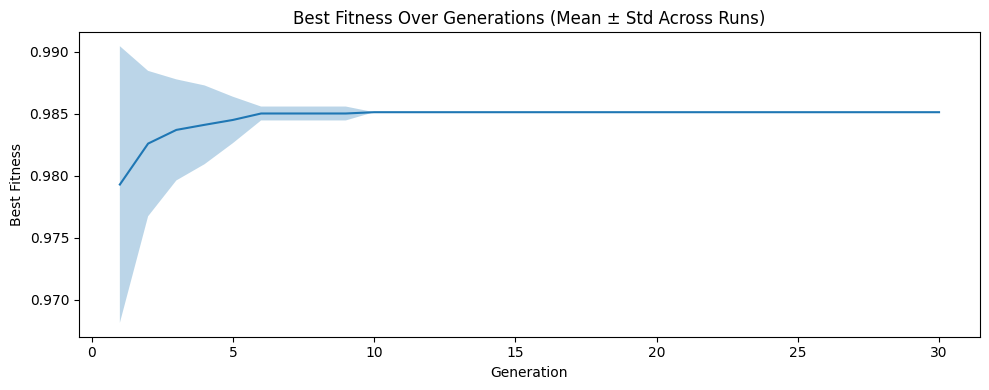

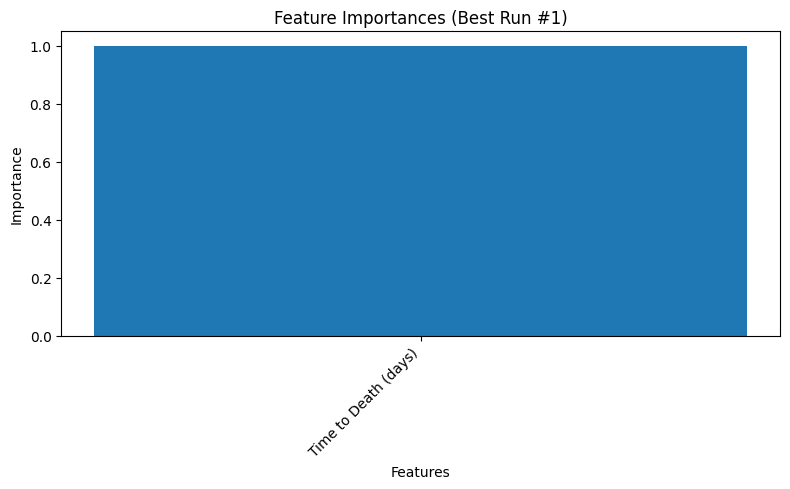

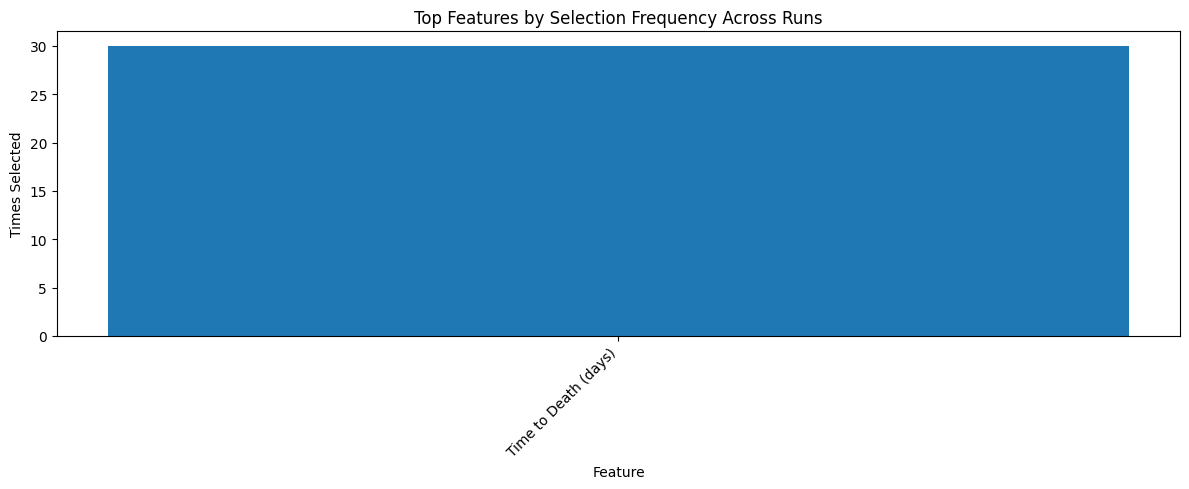


Best Performing Run (Run 1):
  Test Accuracy: 1.0000
  Test F1-Score: 1.0000
  Features Selected (1):
    1. Time to Death (days)

Experiment completed successfully!
Results saved to 'ge_feature_selection_results.json'
Saved plots: 'ge_stats_runs.png', 'ge_fitness_curve_runs.png', 'ge_best_run_feature_importances.png', 'ge_top_features_frequency.png'


In [4]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


class GrammaticalEvolution:
    """
    Grammatical Evolution for feature selection.

      <S> ::= <E>
      <E> ::= <E> <O> <E> | "(" <E> ")" | <N> <E> | <T>
      <O> ::= "&" | "|"
      <N> ::= "!"
      <T> ::= "0"            (placeholder; overwritten by set_features)

    Notes:
      - <T> expands to whole numeric strings (e.g., "0", "1", ..., "12"), ensuring
        multi-digit indices remain a single terminal token so extract_features()
        behaves correctly.
      - The mapper performs a leftmost derivation guided by the genotype.
    """

    def __init__(self,
                 population_size=70,
                 crossover_prob=0.8,
                 mutation_prob=0.1,
                 max_generations=50,
                 max_wraps=3,
                 max_genotype_len=255,
                 max_expansions=500):
        self.population_size = population_size
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.max_generations = max_generations
        self.max_wraps = max_wraps
        self.max_genotype_len = max_genotype_len
        self.max_expansions = max_expansions

        # ---------- Valid grammar ----------
        self.grammar = {
            'S': [['E']],  # <S> ::= <E>
            'E': [['E', 'O', 'E'], ['(', 'E', ')'], ['N', 'E'], ['T']],
            'O': [['&'], ['|']],
            'N': [['!']],
            'T': [['0']]
        }

        self.feature_names = []
        self.n_features = 0

    # ---------------- Utility: features ----------------
    def set_features(self, feature_names):
        """
        Provide feature names and populate <T> with whole-number terminals.
        Terminals remain numeric strings to keep extract_features() simple.
        """
        self.feature_names = list(feature_names)
        self.n_features = len(self.feature_names)
        if self.n_features > 0:
            self.grammar['T'] = [[str(i)] for i in range(self.n_features)]
        else:
            self.grammar['T'] = [['0']]

    # ---------------- GA primitives ----------------
    def generate_individual(self):
        """Generate a random genotype (list of bytes)."""
        return [random.randint(0, 255) for _ in range(self.max_genotype_len)]

    def one_point_crossover(self, parent1, parent2):
        """One-point crossover."""
        if random.random() > self.crossover_prob:
            return parent1.copy(), parent2.copy()
        cut = random.randint(1, min(len(parent1), len(parent2)) - 1)
        c1 = parent1[:cut] + parent2[cut:]
        c2 = parent2[:cut] + parent1[cut:]
        return c1, c2

    def mutate(self, individual):
        """Uniform mutation (byte re-draw)."""
        child = individual.copy()
        for i in range(len(child)):
            if random.random() < self.mutation_prob:
                child[i] = random.randint(0, 255)
        return child

    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        """Tournament selection."""
        selected = []
        n = len(population)
        for _ in range(n):
            idxs = random.sample(range(n), tournament_size)
            fit = [fitness_scores[i] for i in idxs]
            winner = idxs[int(np.argmax(fit))]
            selected.append(population[winner].copy())
        return selected

    # ---------------- Genotype -> Phenotype ----------------
    def map_to_phenotype(self, genotype):
        """
        Leftmost derivation using self.grammar and codons from genotype.
        Returns a list of terminal tokens (operators, parentheses, numeric features).
        """
        phenotype = []
        queue = ['S']  # start symbol
        gene_index = 0
        wraps = 0
        expansions = 0

        while queue and wraps < self.max_wraps and expansions < self.max_expansions:
            current = queue.pop(0)
            if current in self.grammar:
                rules = self.grammar[current]
                if not rules:
                    break
                if gene_index >= len(genotype):
                    gene_index = 0
                    wraps += 1
                    if wraps >= self.max_wraps:
                        break
                codon = genotype[gene_index]
                gene_index += 1
                alt_index = codon % len(rules)
                production = rules[alt_index]
                queue = production + queue
                expansions += 1
            else:
                phenotype.append(current)

        return phenotype

    def extract_features(self, phenotype):
        """
        Extract integer feature indices from phenotype tokens.
        Tokens representing operators/parentheses are ignored.
        """
        features = set()
        for tok in phenotype:
            if tok.isdigit():
                idx = int(tok)
                if 0 <= idx < self.n_features:
                    features.add(idx)
        if not features and self.n_features > 0:
            features.add(random.randint(0, self.n_features - 1))
        return sorted(features)

    # ---------------- Fitness ----------------
    def evaluate_fitness(self, individual, X, y):
        """
        Fitness = 5-fold CV accuracy with RandomForest,
        minus a small penalty for using many features.
        """
        phenotype = self.map_to_phenotype(individual)
        selected = self.extract_features(phenotype)

        if not selected:
            return 0.0

        try:
            X_sel = X[:, selected]
            clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
            scores = cross_val_score(clf, X_sel, y, cv=5, scoring='accuracy')
            fitness = float(np.mean(scores))
            if self.n_features > 0:
                fitness -= 0.1 * (len(selected) / self.n_features)
            return max(0.0, fitness)
        except Exception:
            return 0.0

    # ---------------- Evolution loop ----------------
    def evolve(self, X, y):
        """Run the evolutionary process; return best individual and fitness traces."""
        population = [self.generate_individual() for _ in range(self.population_size)]
        best_hist, avg_hist = [], []

        print(f"Starting evolution with {self.population_size} individuals...")

        for g in range(self.max_generations):
            fitness_scores = [self.evaluate_fitness(ind, X, y) for ind in population]
            best = max(fitness_scores)
            avg = float(np.mean(fitness_scores))
            best_hist.append(best)
            avg_hist.append(avg)
            print(f"Generation {g + 1}: Best = {best:.4f} | Avg = {avg:.4f}")

            # Selection
            selected = self.tournament_selection(population, fitness_scores)

            # Variation
            new_pop = []
            for i in range(0, len(selected), 2):
                p1 = selected[i]
                p2 = selected[i + 1] if i + 1 < len(selected) else selected[0]
                c1, c2 = self.one_point_crossover(p1, p2)
                c1 = self.mutate(c1)
                c2 = self.mutate(c2)
                new_pop.extend([c1, c2])

            # Elitism: keep best from previous generation
            elite_idx = int(np.argmax(fitness_scores))
            if new_pop:
                new_pop[0] = population[elite_idx]

            population = new_pop[:self.population_size]

        final_scores = [self.evaluate_fitness(ind, X, y) for ind in population]
        best_idx = int(np.argmax(final_scores))
        return population[best_idx], best_hist, avg_hist


# ---------------- Data pipeline ----------------
def preprocess_data(file_path):
    """Load CSV, clean, encode, scale."""
    print("Loading and preprocessing data...")
    df = pd.read_csv(file_path)

    # Drop ID/date-like columns if present
    drop_cols = [
        'Case ID', 'Patient affiliation', 'Date of Recurrence',
        'Date of Last Known Alive', 'Date of Death', 'CT Date', 'PET Date'
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    # Determine target column
    if 'Survival Status' in df.columns:
        target_col = 'Survival Status'
    elif 'Recurrence' in df.columns:
        target_col = 'Recurrence'
    else:
        print("Warning: No canonical target found; using first column as target.")
        target_col = df.columns[0]

    y = df[target_col].copy()
    X_df = df.drop(columns=[target_col])

    # Impute
    num_cols = X_df.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        X_df[c] = X_df[c].fillna(X_df[c].median())

    cat_cols = X_df.select_dtypes(include=['object']).columns
    for c in cat_cols:
        mode_val = X_df[c].mode()[0] if not X_df[c].mode().empty else 'Unknown'
        X_df[c] = X_df[c].fillna(mode_val)

    # Encode categoricals
    label_encoders = {}
    for c in cat_cols:
        le = LabelEncoder()
        X_df[c] = le.fit_transform(X_df[c].astype(str))
        label_encoders[c] = le

    # Encode target
    target_encoder = LabelEncoder()
    y_enc = target_encoder.fit_transform(y.astype(str))

    # Scale features
    X = X_df.values
    feature_names = X_df.columns.tolist()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Dataset shape: {X_scaled.shape}")
    print(f"Number of classes: {len(np.unique(y_enc))}")
    print(f"Target distribution: {np.bincount(y_enc)}")

    return X_scaled, y_enc, feature_names, target_encoder, label_encoders


def run_feature_selection_experiment(file_path, num_runs=30):
    """Run multiple independent GE feature selection trials and plot results."""
    print("=" * 60)
    print("GRAMMATICAL EVOLUTION FEATURE SELECTION EXPERIMENT")
    print("=" * 60)

    X, y, feature_names, target_encoder, label_encoders = preprocess_data(file_path)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    ge = GrammaticalEvolution(
        population_size=70, crossover_prob=0.8, mutation_prob=0.1, max_generations=30
    )
    ge.set_features(feature_names)

    all_results = []

    for run in range(num_runs):
        print("\n" + "=" * 40)
        print(f"RUN {run + 1}/{num_runs}")
        print("=" * 40)

        random.seed(run)
        np.random.seed(run)

        best_individual, best_hist, avg_hist = ge.evolve(X_train, y_train)

        phenotype = ge.map_to_phenotype(best_individual)
        selected = ge.extract_features(phenotype)

        # Evaluate on test set
        if selected:
            Xtr_sel = X_train[:, selected]
            Xte_sel = X_test[:, selected]
        else:
            Xtr_sel, Xte_sel = X_train, X_test

        final_clf = RandomForestClassifier(n_estimators=100, random_state=42)
        final_clf.fit(Xtr_sel, y_train)
        y_pred = final_clf.predict(Xte_sel)

        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='weighted')

        result = {
            'run': run + 1,
            'selected_features': selected,
            'n_selected_features': len(selected),
            'selected_feature_names': [feature_names[i] for i in selected],
            'final_fitness': best_hist[-1] if best_hist else None,
            'test_accuracy': float(test_accuracy),
            'test_f1': float(test_f1),
            'fitness_history': [float(x) for x in best_hist]
        }
        all_results.append(result)

        print(f"Selected {len(selected)} features:")
        for i, idx in enumerate(selected):
            print(f"  {i + 1}. {feature_names[idx]}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")

    # ---------- Summary across runs ----------
    print("\n" + "=" * 60)
    print("SUMMARY OF ALL RUNS")
    print("=" * 60)

    test_accuracies = np.array([r['test_accuracy'] for r in all_results], dtype=float)
    test_f1_scores = np.array([r['test_f1'] for r in all_results], dtype=float)
    n_features_selected = np.array([r['n_selected_features'] for r in all_results], dtype=int)

    print(f"Test Accuracy - Mean: {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
    print(f"Test F1-Score - Mean: {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")
    print(f"Features Selected - Mean: {np.mean(n_features_selected):.1f} ± {np.std(n_features_selected):.1f}")
    print(f"Best Test Accuracy: {np.max(test_accuracies):.4f}")
    print(f"Best Test F1-Score: {np.max(test_f1_scores):.4f}")

    # Most frequently selected features (for reference)
    feature_counts = {}
    for result in all_results:
        for idx in result['selected_features']:
            name = feature_names[idx]
            feature_counts[name] = feature_counts.get(name, 0) + 1
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

    # ---------- PLOTS ----------
    # (A) Comprehensive statistics figure for all runs
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs = axs.ravel()

    axs[0].hist(test_accuracies, bins=10)
    axs[0].set_title('Test Accuracy Distribution')
    axs[0].set_xlabel('Accuracy')
    axs[0].set_ylabel('Count')

    axs[1].hist(test_f1_scores, bins=10)
    axs[1].set_title('Test F1-Score Distribution')
    axs[1].set_xlabel('F1-Score')
    axs[1].set_ylabel('Count')

    axs[2].hist(n_features_selected, bins=max(5, n_features_selected.max() - n_features_selected.min() + 1))
    axs[2].set_title('Number of Selected Features')
    axs[2].set_xlabel('# Features')
    axs[2].set_ylabel('Count')

    axs[3].scatter(n_features_selected, test_accuracies)
    axs[3].set_title('Accuracy vs. #Selected Features')
    axs[3].set_xlabel('# Features')
    axs[3].set_ylabel('Accuracy')

    fig.suptitle('Comprehensive Statistics Across Runs', y=0.98)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig('ge_stats_runs.png', dpi=300)
    plt.show()

    # (B) Mean ± Std of best fitness across generations
    # Ensure all have same length; they should as max_generations is fixed.
    fitness_histories = np.array([r['fitness_history'] for r in all_results])
    mean_best = np.mean(fitness_histories, axis=0)
    std_best = np.std(fitness_histories, axis=0)
    gens = np.arange(1, len(mean_best) + 1)

    fig2, ax2 = plt.subplots(figsize=(10, 4))
    ax2.plot(gens, mean_best)
    ax2.fill_between(gens, mean_best - std_best, mean_best + std_best, alpha=0.3)
    ax2.set_title('Best Fitness Over Generations (Mean ± Std Across Runs)')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Best Fitness')
    fig2.tight_layout()
    fig2.savefig('ge_fitness_curve_runs.png', dpi=300)
    plt.show()

    # (C) Feature-importance plot for the best run's selected features
    best_run_idx = int(np.argmax(test_accuracies))
    best_result = all_results[best_run_idx]
    best_selected = best_result['selected_features']
    best_selected_names = [feature_names[i] for i in best_selected]

    if len(best_selected) > 0:
        clf_best = RandomForestClassifier(n_estimators=200, random_state=42)
        clf_best.fit(X_train[:, best_selected], y_train)
        importances = clf_best.feature_importances_
        order = np.argsort(importances)[::-1]
        imp_sorted = importances[order]
        names_sorted = [best_selected_names[i] for i in order]

        fig3, ax3 = plt.subplots(figsize=(max(8, min(16, 0.5 * len(names_sorted) + 4)), 5))
        ax3.bar(range(len(imp_sorted)), imp_sorted)
        ax3.set_xticks(range(len(imp_sorted)))
        ax3.set_xticklabels(names_sorted, rotation=45, ha='right')
        ax3.set_title(f'Feature Importances (Best Run #{best_result["run"]})')
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Importance')
        fig3.tight_layout()
        fig3.savefig('ge_best_run_feature_importances.png', dpi=300)
        plt.show()
    else:
        print("No features selected in best run; skipping feature-importance plot.")

    # Optional: Top-15 most frequent features across runs (bar plot)
    if len(sorted_features) > 0:
        top_k = min(15, len(sorted_features))
        names_top = [x[0] for x in sorted_features[:top_k]]
        counts_top = [x[1] for x in sorted_features[:top_k]]

        fig4, ax4 = plt.subplots(figsize=(12, 5))
        ax4.bar(range(top_k), counts_top)
        ax4.set_xticks(range(top_k))
        ax4.set_xticklabels(names_top, rotation=45, ha='right')
        ax4.set_title('Top Features by Selection Frequency Across Runs')
        ax4.set_xlabel('Feature')
        ax4.set_ylabel('Times Selected')
        fig4.tight_layout()
        fig4.savefig('ge_top_features_frequency.png', dpi=300)
        plt.show()

    # Console recap of best run
    print(f"\nBest Performing Run (Run {best_result['run']}):")
    print(f"  Test Accuracy: {best_result['test_accuracy']:.4f}")
    print(f"  Test F1-Score: {best_result['test_f1']:.4f}")
    print(f"  Features Selected ({best_result['n_selected_features']}):")
    for i, name in enumerate(best_result['selected_feature_names']):
        print(f"    {i + 1}. {name}")

    return all_results


if __name__ == "__main__":
    # Update this path to your CSV
    file_path = r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv"

    try:
        results = run_feature_selection_experiment(file_path, num_runs=30)
        print("\nExperiment completed successfully!")

        # Optional: Save results to file
        import json
        with open('ge_feature_selection_results.json', 'w') as f:
            json.dump(results, f, indent=2)
        print("Results saved to 'ge_feature_selection_results.json'")
        print("Saved plots: "
              "'ge_stats_runs.png', 'ge_fitness_curve_runs.png', "
              "'ge_best_run_feature_importances.png', 'ge_top_features_frequency.png'")

    except FileNotFoundError:
        print(f"Error: Could not find file at {file_path}")
        print("Please make sure the file path is correct.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
